In [ ]:
import torch.nn as nn

## SKConv(Selective Kernel Convolution)
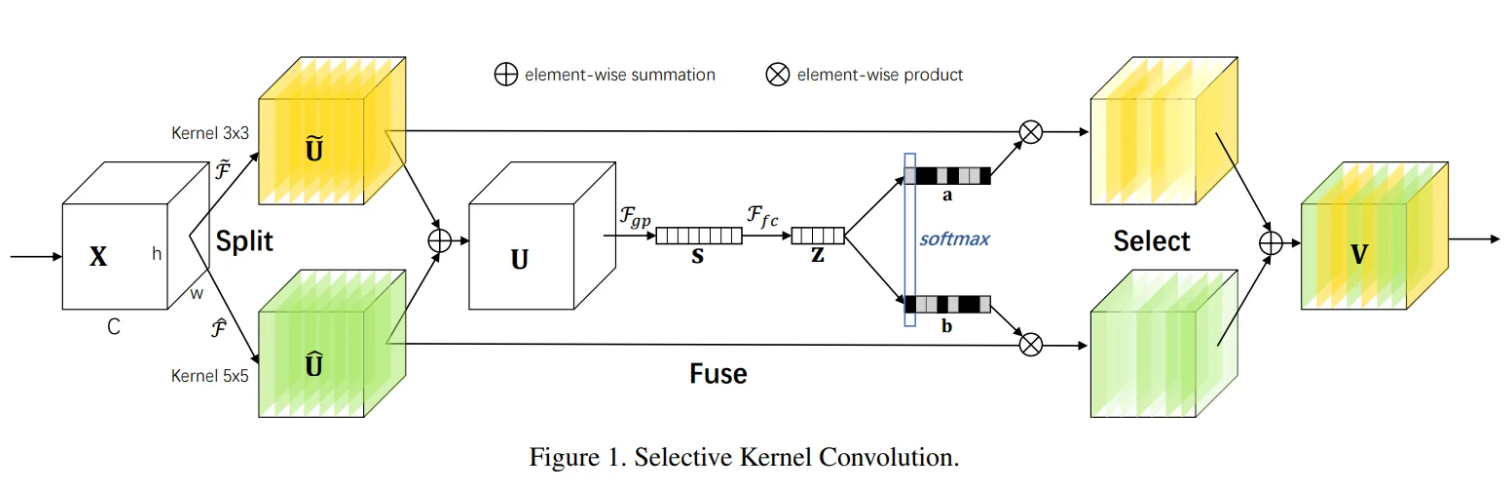

In [ ]:
class SKConv(nn.Module):
# SKConv 클래스: Selective Kernel Convolution 구현
    def __init__(self, features, M=2, G=32, r=16, stride=1, L=32):
        """
        Selective Kernel Convolution 모듈
        Args:
            features: 입력 채널의 크기.
            M: 분기의 개수 (다양한 커널 크기 사용).
            G: 그룹 컨볼루션에서 그룹의 수.
            r: 채널 감소 비율 (z의 길이 계산에 사용).
            stride: 컨볼루션의 stride.
            L: 벡터 z의 최소 차원.
        """
        super(SKConv, self).__init__()
        d = max(int(features / r), L)  # 채널 감소 후 크기 계산
        self.M = M  # 분기의 개수
        self.features = features  # 입력 채널 크기


Split 구현을 위한 다중 커널 합성곱

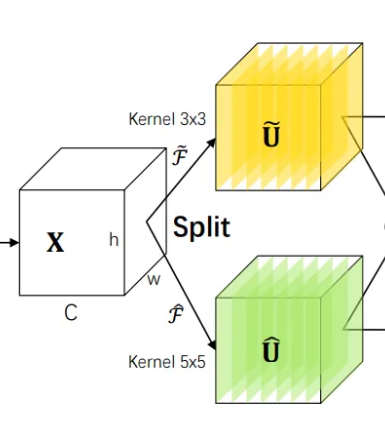

In [ ]:
# 각 분기를 위한 컨볼루션 생성
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(features, features, kernel_size=3, stride=stride, padding=1 + i, dilation=1 + i, groups=G, bias=False),
                nn.BatchNorm2d(features),
                nn.ReLU(inplace=True)
            ) for i in range(M)
        ])

다중 커널 합성곱 결과를 합성해 attention vector 생성

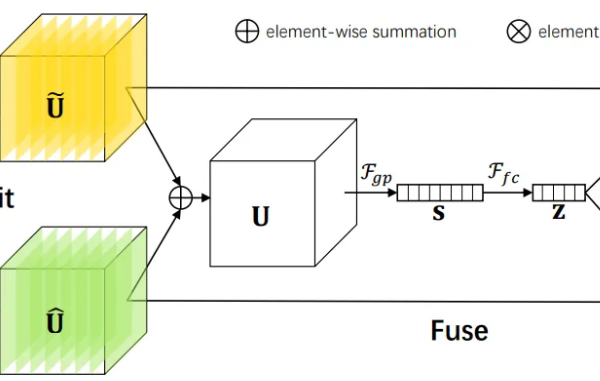


In [ ]:
# Global Average Pooling for z (Fgp)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # 채널 축소를 위한 FC 레이어 for z (Ffc)
        self.fc = nn.Sequential(
            nn.Conv2d(features, d, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(d),
            nn.ReLU(inplace=True)
        )

        # 각 분기의 FC 레이어 (중요도 계산) for a,b (Ac,Bc)
        self.fcs = nn.ModuleList([
            nn.Conv2d(d, features, kernel_size=1, stride=1) for _ in range(M)
        ])

        # Softmax 함수로 중요도 계산
        self.softmax = nn.Softmax(dim=1)

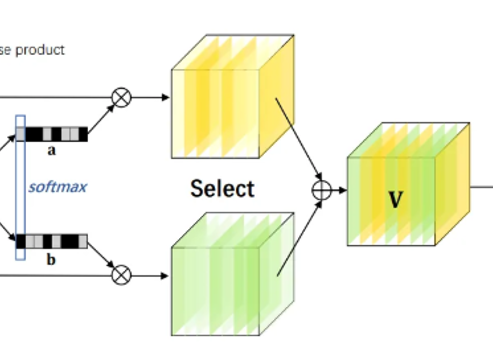

SKConv 구현

In [ ]:
def forward(self, x):
        batch_size = x.shape[0]

        # 각 분기에서 특징 추출
        feats = [conv(x) for conv in self.convs]
        
        feats = torch.cat(feats, dim=1)  # 분기 결과를 채널 방향으로 연결
        # torch.cat을 통해 각 분기의 중요도 벡터를 채널 방향( dim = 1 )으로 결합합니다. 
        # ([8, 256, 56, 56])

        feats = feats.view(batch_size, self.M, self.features, feats.shape[2], feats.shape[3])
        # 결합된 텐서를 [ 𝐵 , 𝑀 × 𝐶 , 1 , 1 ] 에서 [ 𝐵 , 𝑀 , 𝐶 , 1 , 1 ] 로 재구성합니다
        # ([8, 2, 128, 56, 56])  
        # ([8, [0], 128, 56, 56]) / ([8, [1], 128, 56, 56])
        # 배치,분기,입력채널,분기후 피쳐 크기    
        

        # 모든 분기의 특징을 합산하여 U 생성 
        feats_U = torch.sum(feats, dim=1)
        # ([8, 128, 56, 56])


        # Global Average Pooling으로 S 생성(Fgp)
        feats_S = self.gap(feats_U)
        # torch.Size([8, 128, 1, 1])

        # 채널 축소 및 활성화하여 Z 생성(Ffc)
        feats_Z = self.fc(feats_S)
        # torch.Size([8, 32, 1, 1])

        # 각 분기의 중요도 계산
        attention_vectors = [fc(feats_Z) for fc in self.fcs] 
        # A(cz), B(cz) : torch.Size([8, 128, 1, 1])
        attention_vectors = torch.cat(attention_vectors, dim=1)
        # AB : torch.Size([8, 256, 1, 1])
        attention_vectors = attention_vectors.view(batch_size, self.M, self.features, 1, 1)
        # A / B : torch.Size([8, 2 , 128,  1, 1])
        attention_vectors = self.softmax(attention_vectors)
        # ac / bc : torch.Size([8, 2 , 128,  1, 1])

        # 중요도를 기반으로 각 분기의 특징 결합
        feats_V = torch.sum(feats * attention_vectors, dim=1)
        return feats_V

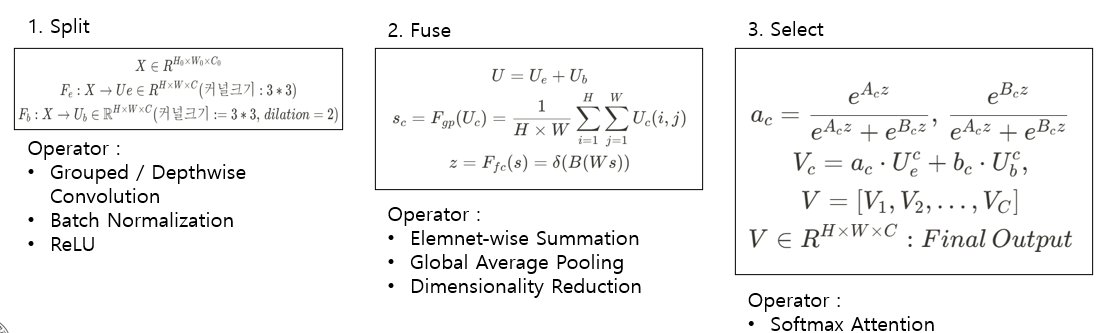
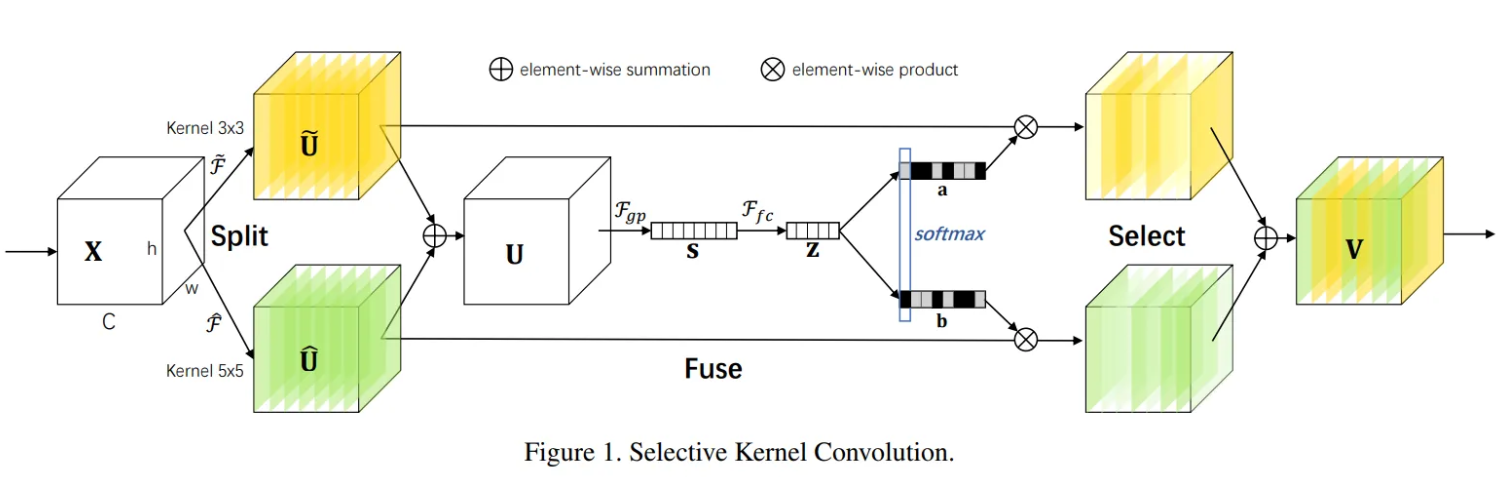

In [ ]:
class SKUnit(nn.Module):
    def __init__(self, in_features, mid_features, out_features, M=2, G=32, r=16, stride=1, L=32):
        """
        Selective Kernel Unit
        Args:
            in_features: 입력 채널 크기.
            mid_features: 중간 채널 크기 (보통 out_features의 절반).
            out_features: 출력 채널 크기.
            M: 분기의 개수.
            G: 그룹 컨볼루션의 그룹 수.
            r: 채널 축소 비율.
            stride: 컨볼루션 stride.
            L: 벡터 z의 최소 차원.
        """
        super(SKUnit, self).__init__()


In [ ]:
        # 첫 번째 1x1 컨볼루션: 채널 축소
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, mid_features, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(mid_features),
            nn.ReLU(inplace=True)
        )

        # SKConv: 분기 구조와 중요도 기반 결합
        self.conv2_sk = SKConv(mid_features, M=M, G=G, r=r, stride=stride, L=L)

        # 두 번째 1x1 컨볼루션: 채널 확장
        self.conv3 = nn.Sequential(
            nn.Conv2d(mid_features, out_features, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_features)
        )

        # Shortcut 연결 (입출력 크기가 같으면 바로 연결, 다르면 변환 후 연결)
        if in_features == out_features and stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_features, out_features, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_features)
            )

        self.relu = nn.ReLU(inplace=True)


In [ ]:
    def forward(self, x):
        residual = x  # 입력값 저장 (Shortcut 연결에 사용)

        # 블록의 연산 수행
        out = self.conv1(x)
        out = self.conv2_sk(out)
        out = self.conv3(out)

        # 출력과 Shortcut 연결 합산 후 활성화
        return self.relu(out + self.shortcut(residual))

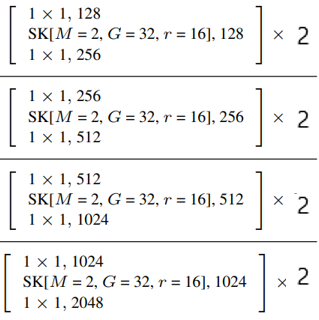

In [ ]:
class SKNet(nn.Module):
    def __init__(self, class_num, nums_block_list=[3, 4, 6, 3], strides_list=[1, 2, 2, 2]):
        """
        Selective Kernel Network
        Args:
            class_num: 최종 분류 클래스 수.
            nums_block_list: 각 스테이지에서 반복될 블록 수.
            strides_list: 각 스테이지의 stride.
        """
        super(SKNet, self).__init__()


In [ ]:
        # 초기 컨볼루션 계층
        self.basic_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # MaxPooling 계층
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 각 스테이지 구성
        self.stage_1 = self._make_layer(64, 128, 256, nums_block=nums_block_list[0], stride=strides_list[0])
        self.stage_2 = self._make_layer(256, 256, 512, nums_block=nums_block_list[1], stride=strides_list[1])
        self.stage_3 = self._make_layer(512, 512, 1024, nums_block=nums_block_list[2], stride=strides_list[2])
        self.stage_4 = self._make_layer(1024, 1024, 2048, nums_block=nums_block_list[3], stride=strides_list[3])

        # Global Average Pooling과 분류 계층
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, class_num)


In [ ]:
    def _make_layer(self, in_feats, mid_feats, out_feats, nums_block, stride=1):
        """
        각 스테이지에 사용되는 블록 구성
        Args:
            in_feats: 입력 채널 크기.
            mid_feats: 중간 채널 크기.
            out_feats: 출력 채널 크기.
            nums_block: 반복될 블록 수.
            stride: 첫 번째 블록의 stride.
        """
        layers = [SKUnit(in_feats, mid_feats, out_feats, stride=stride)]
        for _ in range(1, nums_block):
            layers.append(SKUnit(out_feats, mid_feats, out_feats))
        return nn.Sequential(*layers)


In [ ]:
    def forward(self, x):
        # 네트워크 순전파
        fea = self.basic_conv(x)
        fea = self.maxpool(fea)
        fea = self.stage_1(fea)
        fea = self.stage_2(fea)
        fea = self.stage_3(fea)
        fea = self.stage_4(fea)
        fea = self.gap(fea)
        fea = torch.squeeze(fea)
        fea = self.classifier(fea)
        return fea


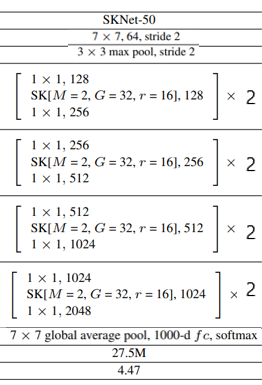

In [ ]:
def SKNet26(num_classes=100):
    return SKNet(num_classes, [2, 2, 2, 2])
